# Comparação LDA × BERTopic × BERTopic-alt
## Métricas de **Granularidade** e **Razoabilidade** dos tópicos

**Objetivo:** comparar os sistemas (pipeline + modelo) gerados em `notebooks/lda` e `notebooks/bertopic` quanto à capacidade de:  
(i) criar tópicos **razoáveis** (interpretáveis) e  
(ii) com **granularidade** adequada (pouca redundância, boa separação e distribuição equilibrada dos tópicos).

**Métricas compostas:**
- **Razoabilidade (RZ)** = z-score combinado de: `C_npmi` (↑), `C_v` (↑) e `Topic Diversity@10` (↑).
- **Granularidade (GR)** = z-score combinado de: **Separação (JSD)** entre tópicos (↑), **Balanço** de tamanhos de tópicos (↑) e **Clareza** de atribuição de documentos (↑).
  - *Separação*: distância Jensen–Shannon média entre distribuições de termos de cada tópico (φ no LDA, c-TF-IDF no BERTopic).
  - *Balanço*: entropia normalizada da distribuição de tamanhos dos tópicos.
  - *Clareza*: LDA = média de `max(θ_d)`; BERTopic = média de `prob` se houver, senão `1 − outliers%`.

**Requisitos de arquivos por *trial*:**
- LDA: `phi_topics.npy`, `theta_docs.npy`, `vocab.txt` (ou `topics_top_words.json`).
- BERTopic: `c_tf_idf.npy`, `vocab.txt`, `doc_topics.csv` (coluna `topic`; opcional `prob`).
- Corpus de referência tokenizado: `data/interim/lda/ref_corpus_tokens.txt` (um doc por linha; tokens separados por espaço).


In [1]:
# Imports e paths
from pathlib import Path
import json, math, os, re, warnings
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from scipy.spatial.distance import jensenshannon

# Coloque este notebook na RAIZ do projeto
ROOT = Path.cwd()
DATA = ROOT / "data"
PROCESSED = DATA / "processed"
RESULTS = ROOT / "results" / "comparison" / datetime.now(timezone.utc).strftime("run_%Y%m%dT%H%M%SZ")
RESULTS.mkdir(parents=True, exist_ok=True)

# Defina o corpus de referência tokenizado (um doc por linha; tokens separados por espaço)
REF_TEXTS_PATH = DATA / "interim" / "lda" / "ref_corpus_tokens.txt"  # ajuste se necessário
if not REF_TEXTS_PATH.exists():
    raise FileNotFoundError(f"Arquivo de referência não encontrado: {REF_TEXTS_PATH}")

# Carrega o corpus de referência (para C_npmi e C_v)
ref_texts = [line.strip().split() for line in open(REF_TEXTS_PATH, encoding="utf-8")]
ref_dict = Dictionary(ref_texts)
print(f"Corpus de referência: {len(ref_texts)} docs | vocab={len(ref_dict)}")

Corpus de referência: 423 docs | vocab=4968


In [2]:
# Funções auxiliares
from pathlib import Path
import json, warnings
import numpy as np
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from scipy.spatial.distance import jensenshannon

def load_vocab(path: Path):
    return [line.strip() for line in open(path, encoding="utf-8")] 

def topics_from_matrix(mat: np.ndarray, vocab: list, topn: int = 10):
    topics = []
    for k in range(mat.shape[0]):
        row = mat[k]
        idx = np.argsort(-row)[:topn]
        topics.append([(vocab[i], float(row[i])) for i in idx])
    return topics

def topic_diversity(topics_terms, topn=10):
    uniq = set(); total = 0
    for terms in topics_terms:
        for w, _ in terms[:topn]: uniq.add(w)
        total += min(len(terms), topn)
    return len(uniq)/total if total else np.nan

def coherence_score(topics_terms, measure: str, ref_texts, ref_dict):
    topics = [[w for (w,_) in t] for t in topics_terms]
    cm = CoherenceModel(topics=topics, texts=ref_texts, dictionary=ref_dict, coherence=measure)
    return float(cm.get_coherence())

def avg_jsd_between_topics(mat: np.ndarray, eps=1e-12, smooth=1e-9):
    """
    Distância Jensen–Shannon média entre tópicos, com suavização:
    - Se uma linha tiver soma zero (tópico degenerado), substitui por distribuição uniforme.
    - Garante que cada linha some ~1 antes de chamar jensenshannon (evita avisos do SciPy).
    """
    if mat.ndim != 2 or mat.shape[0] < 2:
        return np.nan

    V = mat.shape[1]
    prob = mat.astype(float).copy()
    row_sums = prob.sum(axis=1, keepdims=True)

    # linhas totalmente nulas -> uniforme
    zero_rows = (row_sums <= eps).ravel()
    if np.any(zero_rows):
        prob[zero_rows, :] = 1.0 / V
        row_sums = prob.sum(axis=1, keepdims=True)

    # suavização leve e normalização final
    prob += smooth
    prob /= prob.sum(axis=1, keepdims=True)

    ds = []
    for i in range(prob.shape[0]):
        for j in range(i+1, prob.shape[0]):
            d = jensenshannon(prob[i], prob[j])
            if np.isfinite(d):
                ds.append(float(d))
    return float(np.mean(ds)) if ds else np.nan


def size_balance(size_counts: np.ndarray):
    if size_counts is None: return np.nan
    K = len(size_counts)
    if K == 0: return np.nan
    total = size_counts.sum()
    if total == 0: return np.nan
    p = size_counts / total
    p = p[p>0]
    H = -np.sum(p*np.log(p))
    return float(H / np.log(K)) if K>1 else 1.0

def first_existing(*paths: Path):
    for p in paths:
        if p is not None and Path(p).exists():
            return Path(p)
    return None

def load_matrix_auto(path: Path) -> np.ndarray:
    # Aceita .npy ou .npz salvos com numpy.savez (denso)
    if path.suffix == ".npy":
        return np.load(path)
    if path.suffix == ".npz":
        npz = np.load(path)
        key = 'arr_0' if 'arr_0' in npz.files else npz.files[0]
        return npz[key]
    raise ValueError(f"Formato não suportado para matriz: {path}")

def scan_trials(method_root: Path):
    """
    Retorna lista de dicts {'run': <nome_run>, 'tdir': <Path trial>} cobrindo:
    - trials diretos (method_root/trial_*),
    - trials dentro de run_*,
    - e um 'singleton' no nível raiz se houver artefatos padrão lá.
    """
    items = []
    if not method_root.exists():
        return items

    # trials diretos
    for tdir in sorted(method_root.glob("trial_*")):
        items.append({"run": "run_UNGROUPED", "tdir": tdir})

    # trials em run_*
    for rdir in sorted(method_root.glob("run_*")):
        for tdir in sorted(rdir.glob("trial_*")):
            items.append({"run": rdir.name, "tdir": tdir})

    # singleton no nível raiz (artefatos sem trial/run)
    # >>> CORRIGIDO: usa gerador dentro de any()
    singleton_files = ("phi_topics.npy", "c_tf_idf.npy", "c_tf_idf.npz")
    root_has_any = any((method_root / fname).exists() for fname in singleton_files)
    if root_has_any:
        items.append({"run": "run_ROOT", "tdir": method_root})

    return items

def zscore(series: pd.Series):
    std = series.std(ddof=0)
    return (series - series.mean())/std if std not in (0, np.nan) else series*0


In [3]:
# Varredura LDA
lda_root = PROCESSED / "lda"
lda_trials = scan_trials(lda_root)
rows = []
print(f"Trials LDA encontrados: {len(lda_trials)} (somando trials diretos, em run_* e singleton raiz)")

for item in lda_trials:
    tdir = item["tdir"]; run_name = item["run"]
    try:
        phi_p = first_existing(
            tdir/"phi_topics.npy",
            tdir.parent/"phi_topics.npy",
            lda_root/"phi_topics.npy"
        )
        if phi_p is None:
            warnings.warn(f"[LDA] Sem phi_topics em {tdir}")
            continue
        phi = load_matrix_auto(phi_p)

        vocab_p = first_existing(
            tdir/"vocab.txt", tdir.parent/"vocab.txt", lda_root/"vocab.txt"
        )
        if vocab_p is None:
            warnings.warn(f"[LDA] Sem vocab.txt em {tdir}")
            continue
        vocab = load_vocab(vocab_p)

        topics_terms = topics_from_matrix(phi, vocab, topn=10)
        c_npmi = coherence_score(topics_terms, "c_npmi", ref_texts, ref_dict)
        c_v    = coherence_score(topics_terms, "c_v",    ref_texts, ref_dict)
        div    = topic_diversity(topics_terms, topn=10)
        sep    = avg_jsd_between_topics(phi)

        theta_p = first_existing(tdir/"theta_docs.npy", tdir.parent/"theta_docs.npy", lda_root/"theta_docs.npy")
        clarity = np.nan; sizes = None
        if theta_p is not None:
            theta = load_matrix_auto(theta_p)
            clarity = float(np.mean(theta.max(axis=1)))
            dom = theta.argmax(axis=1)
            sizes = np.bincount(dom, minlength=phi.shape[0])
        balance = size_balance(sizes)

        rows.append({
            "method":"lda",
            "run": run_name,
            "trial": tdir.name if tdir.name != "lda" else "trial_ROOT",
            "K": int(phi.shape[0]),
            "c_npmi": c_npmi,
            "c_v": c_v,
            "diversity@10": div,
            "sep_jsd": sep,
            "balance": balance,
            "clarity": clarity,
            "outliers_pct": np.nan
        })
    except Exception as e:
        warnings.warn(f"Falha LDA {tdir}: {e}")

lda_df = pd.DataFrame(rows)
print(f"LDA trials válidos: {len(lda_df)}")
display(lda_df.head())


Trials LDA encontrados: 1 (somando trials diretos, em run_* e singleton raiz)
LDA trials válidos: 1


,method,run,trial,K,c_npmi,c_v,diversity@10,sep_jsd,balance,clarity,outliers_pct
0,lda,run_ROOT,trial_ROOT,5,-0.014792,0.43601,0.52,0.382961,0.964883,0.859328,NaN


In [4]:
# Varredura BERTopic (oficial e 'alt' — ambos em data/processed/bertopic)
bt_root = PROCESSED / "bertopic"
bt_trials = scan_trials(bt_root)
rows = []
print(f"Trials BERTopic encontrados: {len(bt_trials)} (somando trials diretos, em run_* e singleton raiz)")

for item in bt_trials:
    tdir = item["tdir"]; run_name = item["run"]
    try:
        ctf_p = first_existing(
            tdir/"c_tf_idf.npy", tdir/"c_tf_idf.npz",
            tdir.parent/"c_tf_idf.npy", tdir.parent/"c_tf_idf.npz",
            bt_root/"c_tf_idf.npy", bt_root/"c_tf_idf.npz"
        )
        if ctf_p is None:
            warnings.warn(f"[BT] Sem c_tf_idf(.npy|.npz) em {tdir}")
            continue
        ctf = load_matrix_auto(ctf_p)

        vocab_p = first_existing(
            tdir/"vocab.txt", tdir.parent/"vocab.txt", bt_root/"vocab.txt"
        )
        if vocab_p is None:
            warnings.warn(f"[BT] Sem vocab.txt em {tdir}")
            continue
        vocab = load_vocab(vocab_p)

        topics_terms = topics_from_matrix(ctf, vocab, topn=10)
        c_npmi = coherence_score(topics_terms, "c_npmi", ref_texts, ref_dict)
        c_v    = coherence_score(topics_terms, "c_v",    ref_texts, ref_dict)
        div    = topic_diversity(topics_terms, topn=10)
        sep    = avg_jsd_between_topics(ctf)

        lab_p = first_existing(
            tdir/"doc_topics.csv", tdir/"doc_topics_alt.csv",
            tdir.parent/"doc_topics.csv", tdir.parent/"doc_topics_alt.csv",
            bt_root/"doc_topics.csv", bt_root/"doc_topics_alt.csv"
        )
        clarity = np.nan; balance = np.nan; out_pct = np.nan
        if lab_p is not None:
            df_lab = pd.read_csv(lab_p)
            if "topic" in df_lab.columns:
                topics_arr = df_lab["topic"].to_numpy()
                out_pct = float((topics_arr == -1).mean())
                topics_in = topics_arr[topics_arr != -1]
                if topics_in.size > 0:
                    sizes = np.bincount(topics_in, minlength=ctf.shape[0])
                    balance = size_balance(sizes)
                if "prob" in df_lab.columns:
                    clarity = float(np.nanmean(df_lab.loc[df_lab["topic"]!=-1, "prob"]))
                else:
                    clarity = float(1 - out_pct)

        rows.append({
            "method":"bertopic",
            "run": run_name,
            "trial": tdir.name if tdir.name != "bertopic" else "trial_ROOT",
            "K": int(ctf.shape[0]),
            "c_npmi": c_npmi,
            "c_v": c_v,
            "diversity@10": div,
            "sep_jsd": sep,
            "balance": balance,
            "clarity": clarity,
            "outliers_pct": out_pct
        })
    except Exception as e:
        warnings.warn(f"Falha BERTopic {tdir}: {e}")

bt_df = pd.DataFrame(rows)
print(f"BERTopic trials válidos: {len(bt_df)}")
display(bt_df.head())


Trials BERTopic encontrados: 252 (somando trials diretos, em run_* e singleton raiz)


c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\envs\comparison\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\envs\comparison\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\User\AppData\Local\Temp\ipykernel_27608\407283274.py:16: UserWarning: [BT] Sem c_tf_idf(.npy|.npz) em c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\processed\bertopic\trial_18
  warnings.warn(f"[BT] Sem c_tf_idf(.npy|.npz) em {tdir}")
C:\Users\User\AppData\Local\Temp\ipykernel_27608\407283274.py:16: UserWarning: [BT] Sem c_tf_idf(.npy|.npz) em c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\processed\bertopic\run_20250828T182932Z\trial_00
  warnings.warn(f"[BT] Sem c_tf_idf(.npy|.npz) em {tdir}")
C:\Users\

BERTopic trials válidos: 114


,method,run,trial,K,c_npmi,c_v,diversity@10,sep_jsd,balance,clarity,outliers_pct
0,bertopic,run_UNGROUPED,trial_00,5,-0.203553,0.457561,0.880000,0.778612,0.728972,0.715388,0.446809
1,bertopic,run_UNGROUPED,trial_01,2,-0.221326,0.317702,1.000000,0.387071,0.209693,0.966689,0.000000
2,bertopic,run_UNGROUPED,trial_02,3,-0.416192,0.342074,0.966667,0.746927,0.393429,0.855602,0.255319
3,bertopic,run_UNGROUPED,trial_03,6,0.054002,0.601493,0.916667,0.692817,0.814806,0.738267,0.465721
4,bertopic,run_UNGROUPED,trial_04,5,-0.054493,0.653726,0.860000,0.695316,0.817811,0.776616,0.503546


In [5]:
# Consolidação e índices compostos (RZ e GR)
df = pd.concat([lda_df, bt_df], ignore_index=True)

# >>> Filtra soluções triviais (ex.: K < 5)
K_MIN = 5
df = df[df["K"] >= K_MIN].copy()   # ajuste para 6, 8... se quiser

if df.empty:
    print(f"Nenhum trial com K >= {K_MIN}. Ajuste K_MIN ou gere mais trials.")
    print("- Para LDA: salve phi_topics.npy, (opcional) theta_docs.npy e vocab.txt em data/processed/lda/ ou em trial_*/")
    print("- Para BERTopic: salve c_tf_idf.npy, doc_topics.csv e vocab.txt em data/processed/bertopic/ ou em trial_*/")
else:
    # Cenário: ...__opt (pipeline otimizado) ou ...__ctrl (controle)
    df["scenario"] = df["run"].apply(
        lambda s: "opt" if "__opt" in s else ("ctrl" if "__ctrl" in s else "opt")
    )

    def add_composites(group):
        g = group.copy()
        # Razoabilidade
        rz = 0.5*zscore(g["c_npmi"]) + 0.3*zscore(g["c_v"]) + 0.2*zscore(g["diversity@10"])
        # Granularidade
        gr = 0.4*zscore(g["sep_jsd"]) + 0.3*zscore(g["balance"]) + 0.3*zscore(g["clarity"])
        g["RZ_index"] = rz
        g["GR_index"] = gr
        return g

    # Em pandas 2.2.x pode aparecer um DeprecationWarning — é inofensivo aqui
    df = df.groupby("scenario", group_keys=False).apply(add_composites)

    out_csv = RESULTS / "all_trials_gr_rz.csv"
    df.to_csv(out_csv, index=False)
    print(out_csv)
    display(df.sort_values(["scenario","RZ_index"], ascending=[True, False]).head(10))

c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\results\comparison\run_20250901T234941Z\all_trials_gr_rz.csv


C:\Users\User\AppData\Local\Temp\ipykernel_27608\1122324509.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("scenario", group_keys=False).apply(add_composites)


,method,run,trial,K,c_npmi,c_v,diversity@10,sep_jsd,balance,clarity,outliers_pct,scenario,RZ_index,GR_index
17,bertopic,run_UNGROUPED,trial_16,7,0.065974,0.641270,0.900000,0.776793,0.874752,0.716828,0.548463,opt,1.624769,0.264720
16,bertopic,run_UNGROUPED,trial_15,7,0.046785,0.606568,0.942857,0.699104,0.874752,0.716828,0.548463,opt,1.455581,-0.281124
4,bertopic,run_UNGROUPED,trial_03,6,0.054002,0.601493,0.916667,0.692817,0.814806,0.738267,0.465721,opt,1.404626,-0.572065
47,bertopic,run_20250831T231222Z,trial_02,5,-0.009294,0.670476,0.880000,0.796670,0.696235,0.655787,0.368794,opt,1.240696,-0.902046
5,bertopic,run_UNGROUPED,trial_04,5,-0.054493,0.653726,0.860000,0.695316,0.817811,0.776616,0.503546,opt,0.823544,-0.361716
36,bertopic,run_20250831T230602Z,trial_22,9,0.004859,0.613065,0.755556,0.765269,0.922191,0.652358,0.378251,opt,0.712980,0.161633
63,bertopic,run_20250831T231222Z,trial_22,9,0.004859,0.613065,0.755556,0.765269,0.922191,0.652358,0.378251,opt,0.712980,0.161633
98,bertopic,run_20250901T165942Z,trial_22,9,0.004859,0.613065,0.755556,0.765269,0.922191,0.652358,0.378251,opt,0.712980,0.161633
38,bertopic,run_20250831T230602Z,trial_24,12,0.007560,0.605860,0.750000,0.789578,0.926204,0.603602,0.144208,opt,0.680042,0.132388
65,bertopic,run_20250831T231222Z,trial_24,12,0.007560,0.605860,0.750000,0.789578,0.926204,0.603602,0.144208,opt,0.680042,0.132388


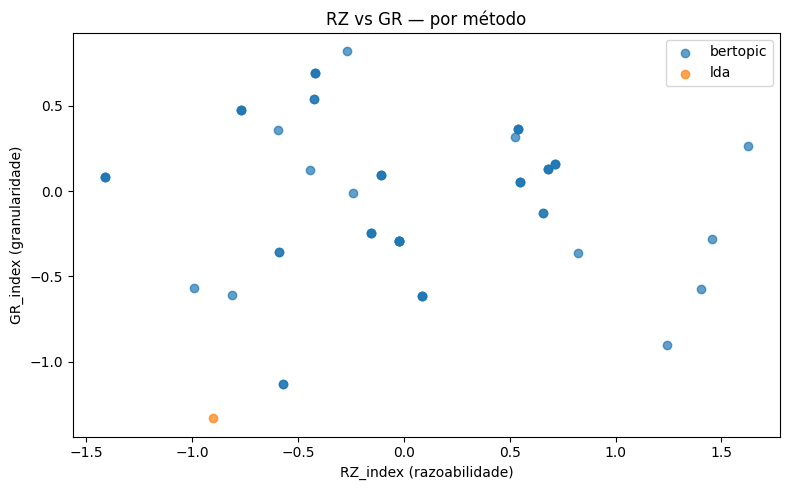

<Figure size 800x500 with 0 Axes>

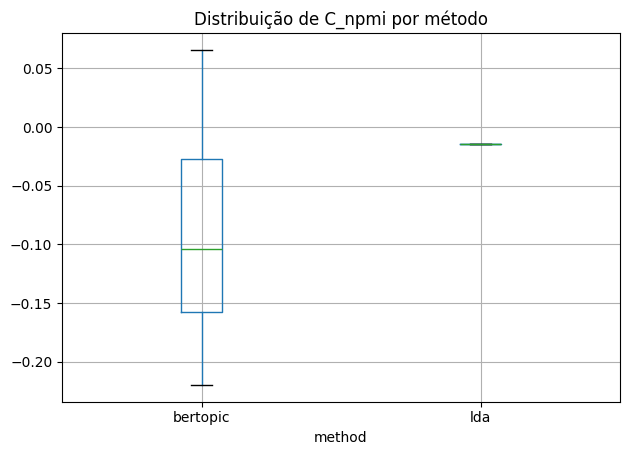

<Figure size 800x500 with 0 Axes>

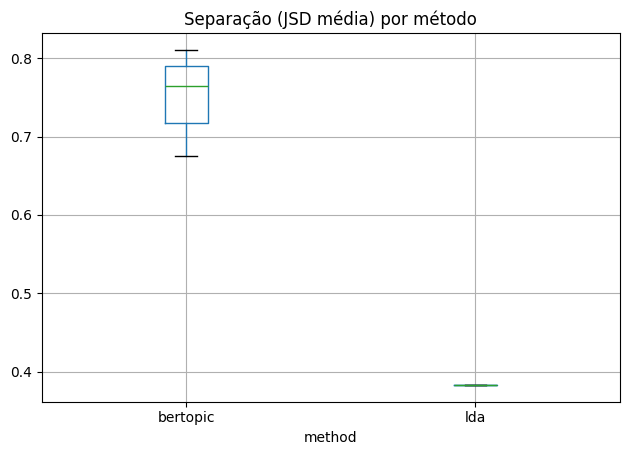

In [6]:
# Gráficos (matplotlib, sem estilos específicos)
plt.figure(figsize=(8,5))
for m in sorted(df['method'].unique()):
    sub = df[df['method']==m]
    plt.scatter(sub['RZ_index'], sub['GR_index'], label=m, alpha=0.7)
plt.xlabel('RZ_index (razoabilidade)')
plt.ylabel('GR_index (granularidade)')
plt.title('RZ vs GR — por método')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
df.boxplot(column='c_npmi', by='method')
plt.suptitle('')
plt.title('Distribuição de C_npmi por método')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
df.boxplot(column='sep_jsd', by='method')
plt.suptitle('')
plt.title('Separação (JSD média) por método')
plt.tight_layout()
plt.show()


In [7]:
# Exporta planilha com réplicas e índices GR/RZ
xlsx_out = ROOT / "reports" / "tables" / "TCC_comparacao_GR_RZ.xlsx"
xlsx_out.parent.mkdir(parents=True, exist_ok=True)
with pd.ExcelWriter(xlsx_out, engine='openpyxl') as writer:
    df.to_excel(writer, index=False, sheet_name='Replicacoes')
print(f"Planilha escrita em: {xlsx_out}")


Planilha escrita em: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\reports\tables\TCC_comparacao_GR_RZ.xlsx


In [8]:
# Exporta o melhor BERTopic com cobertura mínima (ex.: 70%)
import shutil

COVER_MIN = 0.70
df2 = df[(df["method"]=="bertopic") & (df["outliers_pct"]<= (1-COVER_MIN))] \
        .sort_values(["RZ_index","GR_index"], ascending=False)

assert not df2.empty, "Nenhum trial atende à cobertura mínima; ajuste COVER_MIN."
best = df2.iloc[0]
print("Selecionado:", best["run"], best["trial"], "| K=", int(best["K"]))

# Resolve caminho do trial
bt_root = PROCESSED / "bertopic"
if best["run"].startswith("run_"):
    src = bt_root / best["run"] / best["trial"]
else:
    src = bt_root / best["trial"]
assert src.exists(), f"Pasta de trial não encontrada: {src}"

# Pasta de export
export_dir = DATA / "exports" / "dashboard" / "bertopic_best"
export_dir.mkdir(parents=True, exist_ok=True)

# Copia artefatos essenciais
for fname in ["c_tf_idf.npy","vocab.txt","doc_topics.csv","topic_info.csv"]:
    f = src / fname
    if f.exists():
        shutil.copy2(f, export_dir / fname)

# Manifesto com métricas/identidade da seleção
with open(export_dir/"selection.json","w",encoding="utf-8") as f:
    json.dump(best.to_dict(), f, ensure_ascii=False, indent=2)

print("Exportado para:", export_dir)

Selecionado: run_20250831T230602Z trial_24 | K= 12
Exportado para: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\exports\dashboard\bertopic_best


In [9]:
# (Opcional) Métricas de alinhamento com orientadores
from sklearn.metrics import normalized_mutual_info_score as nmi

ORIENTADORES_CSV = DATA / "interim" / "meta_orientadores.csv"  # ajuste para o seu arquivo
if not ORIENTADORES_CSV.exists():
    print(f"[Opcional] Arquivo de orientadores não encontrado: {ORIENTADORES_CSV}")
else:
    meta = pd.read_csv(ORIENTADORES_CSV)
    assert {"DOC_ID","orientador"}.issubset(meta.columns), "CSV precisa ter colunas DOC_ID e orientador"
    meta["DOC_ID"] = meta["DOC_ID"].astype(int)

    out_rows = []
    # LDA: usa argmax(θ) como rótulo de tópico do doc
    for tdir in scan_trials(PROCESSED / "lda"):
        theta_p = tdir/"theta_docs.npy"
        if not theta_p.exists(): 
            continue
        theta = np.load(theta_p)
        doc_labels = theta.argmax(axis=1)
        df_join = pd.DataFrame({"DOC_ID": np.arange(len(doc_labels)), "topic": doc_labels}).merge(meta, on="DOC_ID", how="inner")
        if df_join.empty: 
            continue
        # pureza por orientador (1 - entropia normalizada)
        scores = []
        for o, grp in df_join.groupby("orientador"):
            counts = np.bincount(grp["topic"].to_numpy(), minlength=theta.shape[1])
            bal = size_balance(counts)   # usa função de entropia normalizada já definida
            scores.append(bal)
        pureza_media = float(np.mean(scores)) if scores else np.nan
        # NMI global
        nmi_global = float(nmi(df_join["orientador"].astype(str), df_join["topic"]))
        out_rows.append({"method":"lda","run":tdir.parent.name,"trial":tdir.name,"pureza_orientador":pureza_media,"nmi_orientador":nmi_global})

    # BERTopic: usa doc_topics.csv (coluna topic), ignorando -1
    for tdir in scan_trials(PROCESSED / "bertopic"):
        lab_p = tdir/"doc_topics.csv"
        if not lab_p.exists(): 
            continue
        labels = pd.read_csv(lab_p)
        assert "DOC_ID" in labels.columns and "topic" in labels.columns, "doc_topics.csv precisa ter DOC_ID e topic"
        df_join = labels[labels["topic"]!=-1][["DOC_ID","topic"]].merge(meta, on="DOC_ID", how="inner")
        if df_join.empty: 
            continue
        K_eff = int(df_join["topic"].max())+1
        scores = []
        for o, grp in df_join.groupby("orientador"):
            counts = np.bincount(grp["topic"].to_numpy(), minlength=K_eff)
            bal = size_balance(counts)
            scores.append(bal)
        pureza_media = float(np.mean(scores)) if scores else np.nan
        nmi_global = float(nmi(df_join["orientador"].astype(str), df_join["topic"]))
        out_rows.append({"method":"bertopic","run":tdir.parent.name,"trial":tdir.name,"pureza_orientador":pureza_media,"nmi_orientador":nmi_global})

    orient_df = pd.DataFrame(out_rows)
    display(orient_df.sort_values(["method","pureza_orientador"], ascending=[True, False]).head(10))
    # salva junto do CSV principal
    orient_out = RESULTS / "orientadores_metrics.csv"
    orient_df.to_csv(orient_out, index=False)
    print(orient_out)


[Opcional] Arquivo de orientadores não encontrado: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\interim\meta_orientadores.csv


,model,K,c_v,c_npmi,topic_diversity@10,sep_jsd,balance,clarity,RZ_index,GR_index
0,LDA (K=5),5,0.43601,-0.014792,None,0.382961,0.964883,0.859328,-0.904069,-1.331650
1,BERTopic alt (K=12),12,0.60586,0.007560,None,0.789578,0.926204,0.603602,0.680042,0.132388


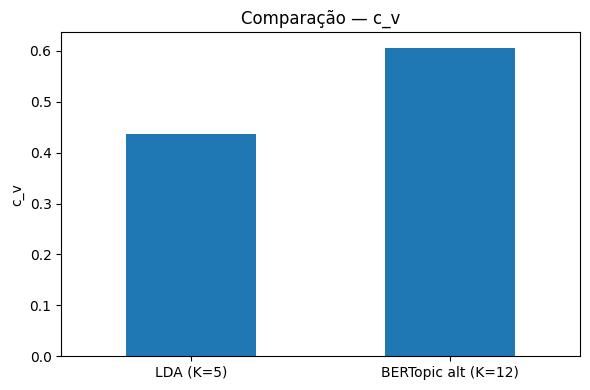

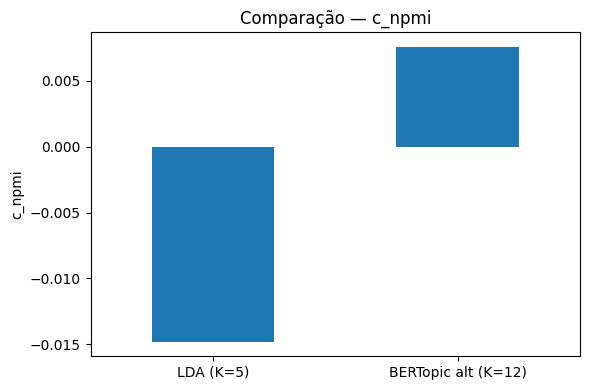

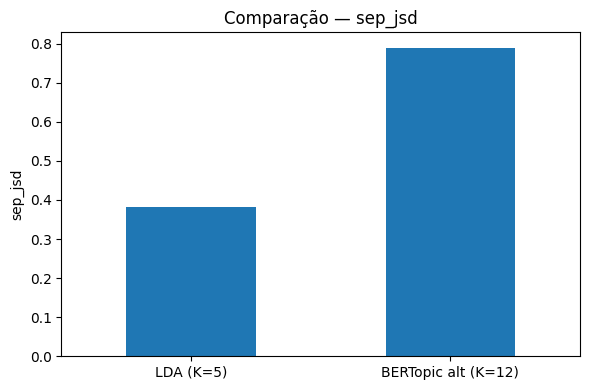

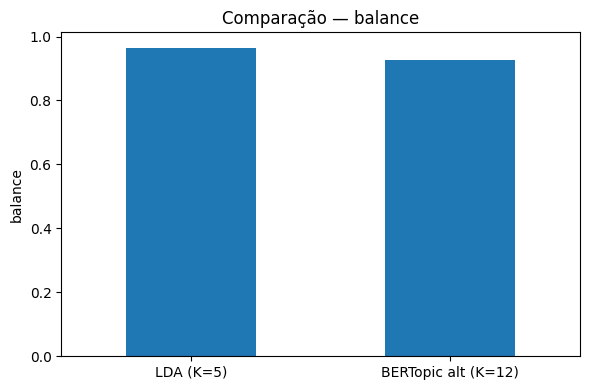

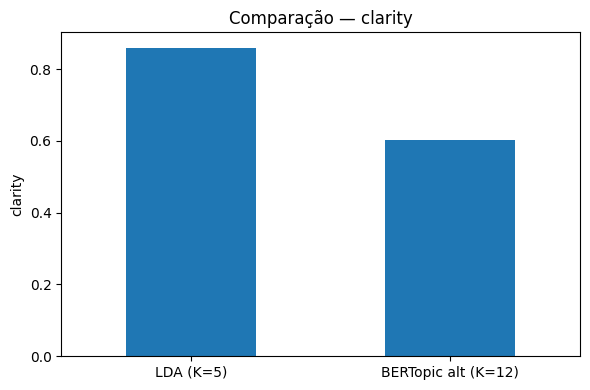

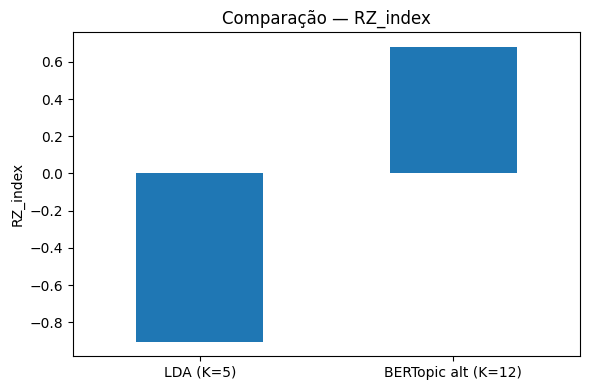

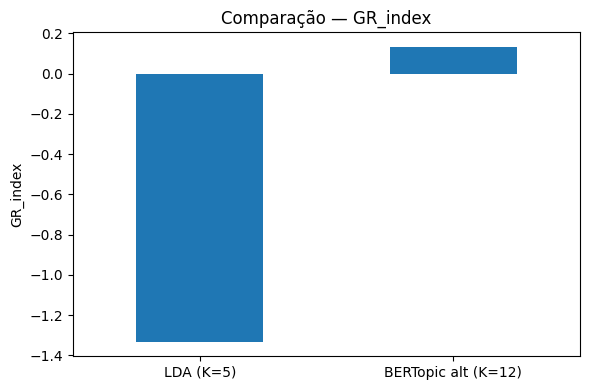

Arquivos salvos em reports\tables e reports\figures


In [ ]:
# === RESUMO FINAL A PARTIR DO CONSOLIDADO all_trials_gr_rz.csv (versão corrigida) ===
import json, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

ROOT = Path(".")
OUT_TB = ROOT/"reports"/"tables"; OUT_TB.mkdir(parents=True, exist_ok=True)
OUT_FG = ROOT/"reports"/"figures"; OUT_FG.mkdir(parents=True, exist_ok=True)

# 1) carrega o consolidado (pega o mais recente)
cons = sorted((ROOT/"results"/"comparison").rglob("all_trials_gr_rz.csv"))[-1]
df = pd.read_csv(cons)

# helper para pegar diversity com nome que existir no CSV
def get_diversity(row):
    if "topic_diversity@10" in row.index and pd.notna(row["topic_diversity@10"]):
        return row["topic_diversity@10"]
    if "diversity@10" in row.index and pd.notna(row["diversity@10"]):
        return row["diversity@10"]
    return None

# 2) escolhe as linhas-alvo
#    - LDA: prioriza a linha de K=5 (se existir); senão, melhor por RZ/GR
lda_rows = df.query("method == 'lda'")
if len(lda_rows) and "K" in lda_rows.columns and (lda_rows["K"] == 5).any():
    lda_row = lda_rows.loc[lda_rows["K"] == 5].iloc[0]
else:
    lda_row = lda_rows.sort_values(["RZ_index","GR_index"], ascending=False).iloc[0] if len(lda_rows) else None

#    - BERTopic alt: usa o selection.json exportado para o dashboard
sel_path = ROOT/"data"/"exports"/"dashboard"/"bertopic_best"/"selection.json"
sel = json.loads(sel_path.read_text(encoding="utf-8"))
run, trial = sel.get("run"), sel.get("trial")

bt_rows = df.query("method == 'bertopic'")
if {"run","trial"}.issubset(bt_rows.columns):
    hit = bt_rows.query("run == @run and trial == @trial")
    bt_alt_row = hit.iloc[0] if len(hit) else bt_rows.sort_values(["RZ_index","GR_index"], ascending=False).iloc[0]
else:
    # fallback: melhor por RZ/GR com cobertura mínima (se a coluna existir)
    bt_tmp = bt_rows.copy()
    if "outliers_pct" in bt_tmp.columns:
        bt_tmp = bt_tmp.query("outliers_pct <= 0.30")
    bt_alt_row = bt_tmp.sort_values(["RZ_index","GR_index"], ascending=False).iloc[0]

#    - (Opcional) BERTopic oficial: defina include_official=True para incluir nas barras
include_official = False
bt_off_row = None
if include_official:
    # normalmente K=2; pode ter sido filtrado no run. Se existir, pega o de menor ruído.
    cand = bt_rows.query("K == 2") if "K" in bt_rows.columns else bt_rows.head(0)
    if len(cand):
        if "outliers_pct" in cand.columns:
            bt_off_row = cand.sort_values(["outliers_pct","RZ_index"], ascending=[True,False]).iloc[0]
        else:
            bt_off_row = cand.sort_values(["RZ_index","GR_index"], ascending=False).iloc[0]

# 3) compõe o DataFrame de comparação (garante diversity correta)
rows = []
if lda_row is not None:
    rows.append({
        "model": f"LDA (K={int(lda_row['K'])})" if "K" in lda_row else "LDA",
        "K": int(lda_row.get("K", 5)) if pd.notna(lda_row.get("K", 5)) else 5,
        "c_v": lda_row.get("c_v"),
        "c_npmi": lda_row.get("c_npmi"),
        "topic_diversity@10": get_diversity(lda_row),
        "sep_jsd": lda_row.get("sep_jsd"),
        "balance": lda_row.get("balance"),
        "clarity": lda_row.get("clarity"),
        "RZ_index": lda_row.get("RZ_index"),
        "GR_index": lda_row.get("GR_index"),
    })

rows.append({
    "model": f"BERTopic alt (K={int(bt_alt_row['K'])})" if "K" in bt_alt_row else "BERTopic alt",
    "K": int(bt_alt_row.get("K", 0)) if pd.notna(bt_alt_row.get("K", 0)) else 0,
    "c_v": bt_alt_row.get("c_v"),
    "c_npmi": bt_alt_row.get("c_npmi"),
    "topic_diversity@10": get_diversity(bt_alt_row),
    "sep_jsd": bt_alt_row.get("sep_jsd"),
    "balance": bt_alt_row.get("balance"),
    "clarity": bt_alt_row.get("clarity"),
    "RZ_index": bt_alt_row.get("RZ_index"),
    "GR_index": bt_alt_row.get("GR_index"),
})
if bt_off_row is not None:
    rows.append({
        "model": f"BERTopic oficial (K={int(bt_off_row['K'])})" if "K" in bt_off_row else "BERTopic oficial",
        "K": int(bt_off_row.get("K", 0)) if pd.notna(bt_off_row.get("K", 0)) else 0,
        "c_v": bt_off_row.get("c_v"),
        "c_npmi": bt_off_row.get("c_npmi"),
        "topic_diversity@10": get_diversity(bt_off_row),
        "sep_jsd": bt_off_row.get("sep_jsd"),
        "balance": bt_off_row.get("balance"),
        "clarity": bt_off_row.get("clarity"),
        "RZ_index": bt_off_row.get("RZ_index"),
        "GR_index": bt_off_row.get("GR_index"),
    })

df_comp = pd.DataFrame(rows, columns=[
    "model","K","c_v","c_npmi","topic_diversity@10","sep_jsd","balance","clarity","RZ_index","GR_index"
])
df_comp.to_csv(OUT_TB/"compare_models_summary.csv", index=False, encoding="utf-8")
display(df_comp)

# 4) gráficos de barras para várias métricas (agora com 2-3 barras)
def barplot(metric, fname):
    sub = df_comp[["model", metric]].dropna()
    if not len(sub): 
        return
    ax = sub.plot(kind="bar", x="model", y=metric, legend=False, rot=0, figsize=(9,6))
    ax.set_xlabel(""); ax.set_ylabel(metric); ax.set_title(f"Comparação — {metric}")
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}", (p.get_x()+p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=9, rotation=0)
    plt.tight_layout(); plt.savefig(OUT_FG/fname, dpi=150); plt.show()

for m, fn in [
    ("c_v","compare_c_v.png"),
    ("c_npmi","compare_c_npmi.png"),
    ("topic_diversity@10","compare_diversity.png"),
    ("sep_jsd","compare_sep_jsd.png"),
    ("balance","compare_balance.png"),
    ("clarity","compare_clarity.png"),
    ("RZ_index","compare_RZ.png"),
    ("GR_index","compare_GR.png"),
]:
    barplot(m, fn)

print("Arquivos salvos em", OUT_TB, "e", OUT_FG)